In [91]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [92]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [93]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [94]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [95]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [96]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [97]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [98]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [99]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()

most_recent_date

'2017-08-23'

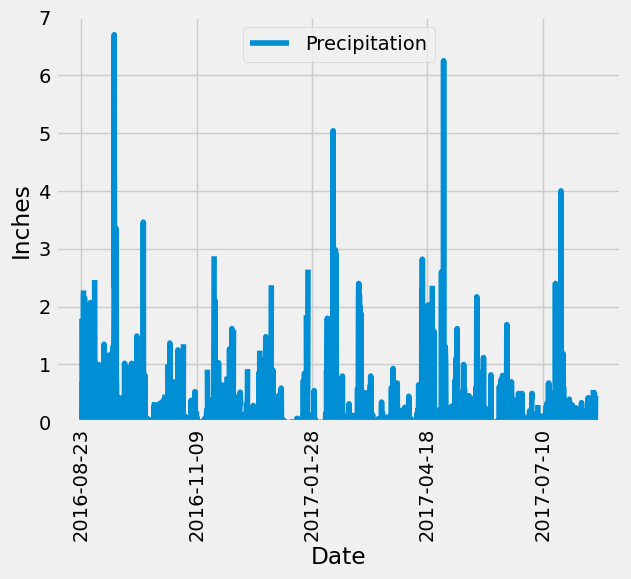

In [105]:
# Design a query to retrieve the last 12 months of precipitation data starting from the most recent data point in the database
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores without passing the date as a variable.
precipitation_data = session.query(measurement.date, measurement.prcp).\
                    filter(measurement.date >= 
                           (func.date(most_recent_date, '-1 year'))).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(6.5, 5))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.ylim(0, 7)
plt.show()

In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()

pd.DataFrame(summary_statistics)


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station.distinct())).scalar()
total_stations

9

In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(measurement.station, func.count(measurement.station).label('station_count')) \
                        .group_by(measurement.station) \
                        .order_by(func.count(measurement.station).desc()) \
                        .all()

# List the stations and their counts in descending order.
for station in active_stations:
    print(f"Station: {station.station}, {station.station_count}")

Station: USC00519281, 2772
Station: USC00519397, 2724
Station: USC00513117, 2709
Station: USC00519523, 2669
Station: USC00516128, 2612
Station: USC00514830, 2202
Station: USC00511918, 1979
Station: USC00517948, 1372
Station: USC00518838, 511


In [67]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

results = session.query(func.min(measurement.tobs).label('min_temp'),
                        func.max(measurement.tobs).label('max_temp'),
                        func.avg(measurement.tobs).label('avg_temp')) \
                    .filter(measurement.station == most_active_station_id) \
                    .all()

# Print the results
for result in results:
    print(f"{result.min_temp}, {result.max_temp}, {result.avg_temp}")


54.0, 85.0, 71.66378066378067


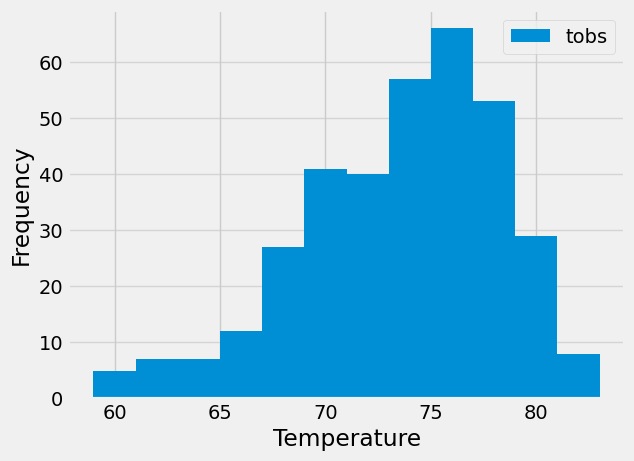

In [89]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

start_date = '2016-08-23'
end_date = '2017-08-23'

results = session.query(measurement.tobs) \
                 .filter(measurement.station == most_active_station_id) \
                 .filter(measurement.date >= start_date) \
                 .filter(measurement.date <= end_date) \
                 .all()

# Save the query results to a Pandas DataFrame
df = pd.DataFrame(results, columns=['Temperature'])

# Plot the results as a histogram
plt.hist(df['Temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend(['tobs'])
plt.show()

# Close Session

In [90]:
# Close Session
session.close()